# Trading With Momentum

<em>Aspiration</em>

This notebook was created with the purpose to obtain insights about volatility by finding buying opportunities in short-term uptrends and then sell when the securities start to lose momentum.

## Introduction to Momentum Trading

> <a href="https://www.investopedia.com/trading/introduction-to-momentum-trading/" target="_black">Momentum investing</a> seeks to take advantage of market volatility by taking short-term positions in stocks going up and selling them as soon as they show signs of going down.

## Data Overview

<b>Libraries used</b>

In [886]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from functools import reduce
from scipy import stats

**Market Data** 
<br><br>

Historical data of several companies were selected without any kind of filter from Yahoo finance.

And the period of historial data selected was from <em>Dec 31, 2017</em> to <em>Jun 02, 2021</em>

In [887]:
folder_name = 'stocks_historical_data'
stock_names = [w.replace('.csv', '') for w in os.listdir(folder_name)]
print('STOCKS SELECTED: ')
print(stock_names)

STOCKS SELECTED: 
['FMC', 'MMM', 'ADSK', 'KO', 'CCL', 'ATVI', 'NFLX', 'LEN', 'TSLA', 'AAL', 'DAL', 'AAPL', 'HAS']


<b>Stocks's Historical Data Visualization</b>
<br><br>

Let's import each stock data, join all into one data frame and then create a chart for a better visualization

In [888]:
dfs = [] #array for each data frame
folder_name = './stocks_historical_data/'

for name in os.listdir(folder_name):
    dfs.append(pd.read_csv(folder_name + name, parse_dates=['Date'], index_col=False))

Let's take a look of how the data set is organized

In [889]:
dfs[0].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,82.723328,83.217690,82.471809,83.026886,78.704277,1361693
1,2018-01-03,83.200348,84.189072,82.688637,84.093666,79.715530,1090046
2,2018-01-04,84.648743,85.594101,84.223763,84.518646,80.118385,1176752
3,2018-01-05,84.969643,85.411972,84.388550,85.065048,80.636337,1291937
4,2018-01-08,85.429314,85.559410,84.483955,85.143105,80.710320,891846


Since our goal is to only look at <b>closing</b> stock price, lets select only this column and join all dataframes imported into one large data set with respective data sets names.

In [890]:
for i in range(len(dfs)):
    dfs[i] = dfs[i].rename(columns={"Close": stock_names[i].lower()}).set_index('Date')[stock_names[i].lower()]


Now we have a single data frame with stock closing price for each company and date

In [891]:
close_prices = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
close_prices = close_prices.reset_index()
close_prices.tail()

,Date,fmc,mmm,adsk,ko,ccl,atvi,nflx,len,tsla,aal,dal,aapl,has
855,2021-05-26,115.400002,201.580002,292.510010,55.029999,29.370001,97.300003,502.359985,98.809998,619.130005,23.90,47.490002,126.849998,94.830002
856,2021-05-27,116.239998,203.240005,286.670013,55.490002,30.000000,97.250000,503.859985,98.949997,630.849976,24.43,48.049999,125.279999,95.919998
857,2021-05-28,116.690002,203.039993,285.859985,55.290001,29.559999,97.250000,502.809998,99.010002,625.219971,24.24,47.680000,124.610001,95.970001
858,2021-06-01,118.309998,203.199997,281.299988,55.279999,30.150000,96.449997,499.079987,98.500000,623.900024,24.67,47.700001,124.279999,96.290001
859,2021-06-02,117.699997,203.289993,279.670013,55.500000,31.309999,95.389999,499.239990,96.349998,605.119995,25.82,47.770000,125.059998,95.459999


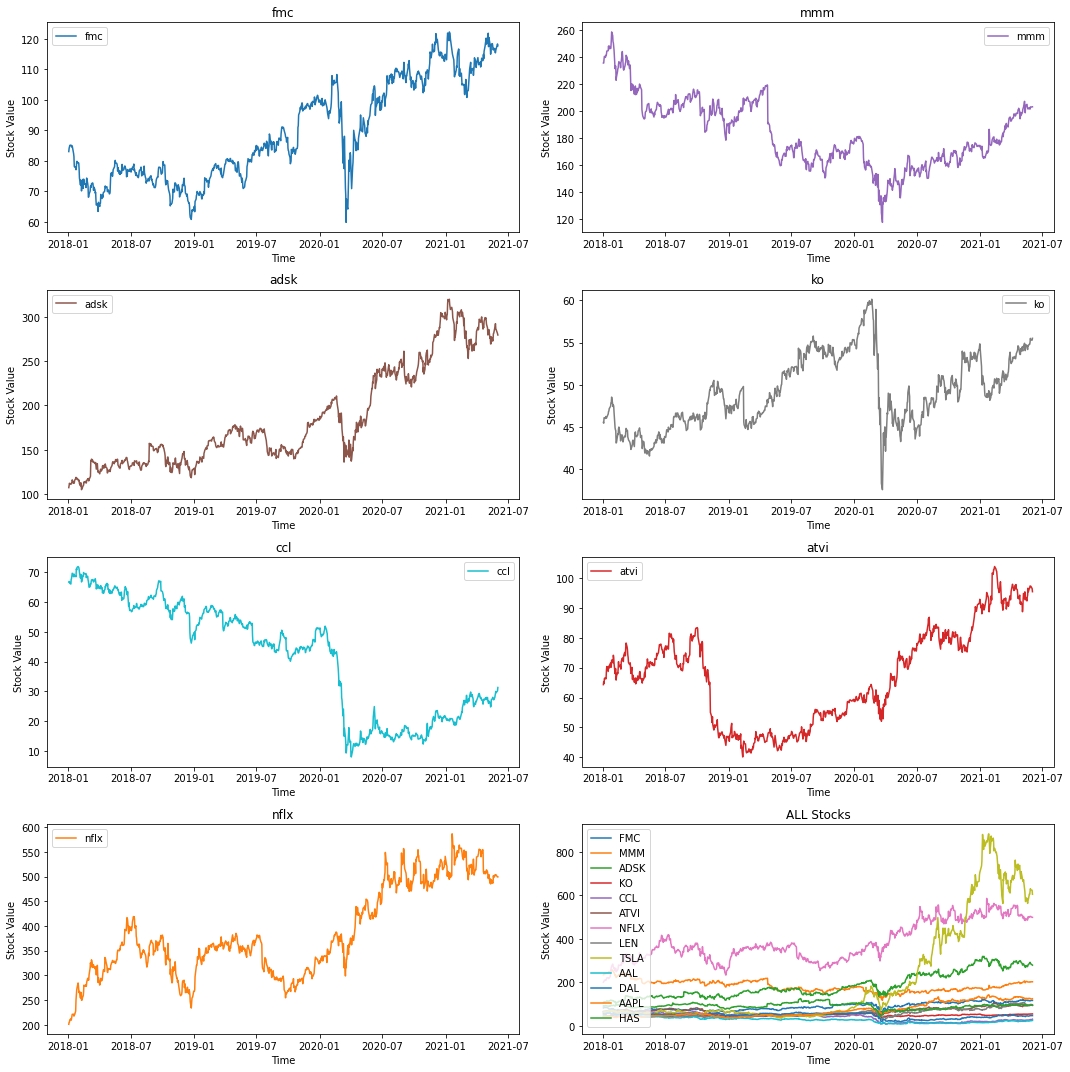

In [892]:
def plotClosePrices(df=close_prices, stock_names=stock_names, nrows=4, ncols=2, figsize=(15,15)):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.patch.set_facecolor('xkcd:white')

    list_colors = ['tab:blue', 'tab:purple', 'tab:brown', 'tab:gray', 'tab:cyan', 'tab:red', 'tab:orange']

    k = 0
    for i in range(4):
        for j in range(2):
            if k == 7:
                df = df.set_index('Date')
                name = 'ALL Stocks'
                axs[i, j].set_title(name)
                axs[i, j].plot(df.index, df)
                axs[i, j].set_xlabel("Time")
                axs[i, j].set_ylabel("Stock Value")
                axs[i, j].legend(stock_names, loc='upper left')
            else:
                name = stock_names[k].lower()
                axs[i, j].set_title(name)
                axs[i, j].plot(df['Date'], df[name], color=list_colors[k])
                axs[i, j].set_xlabel("Time")
                axs[i, j].set_ylabel("Stock Value")
                axs[i, j].legend([name])
            k+=1

    fig.tight_layout()
plotClosePrices()

## Resample Adjusted Prices

The trading signal we've developed does not need to be based on daily prices, for instance, it can use month-end prices to perform trading once a month. To do this, we had to first resample the daily adjusted closing prices into monthly buckets, and then select the last observation of each month.

In [893]:
def resample_prices(close_prices, freq='M'):
    """
    Parameters
    ----------
    close_prices : DataFrame
        Close prices for each ticker and date
    freq : str
        What frequency to sample at
        For valid freq choices, see http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
    
    Returns
    -------
    prices_resampled : DataFrame
        Resampled prices for each ticker and date
    """
    
    
    return close_prices.resample(freq, on='Date').mean()

# Lets reorganize the data in order to get montly close prices
monthly_close_returns = resample_prices(close_prices).reset_index()
monthly_close_returns.head()

,Date,fmc,mmm,adsk,ko,ccl,atvi,nflx,len,tsla,aal,dal,aapl,has
0,2018-01-31,81.500433,245.562858,113.863334,46.797143,68.988572,69.228572,232.908096,68.133333,67.716666,54.902857,57.202857,43.501309,92.858571
1,2018-02-28,72.630667,234.961053,112.075263,44.332105,68.783684,70.237895,271.443683,59.498421,67.155474,51.838947,53.066841,41.909737,96.821579
2,2018-03-31,69.351589,230.240000,130.651429,43.567142,66.330001,72.278096,312.228097,59.009524,63.196666,53.804286,55.022381,43.624048,89.072381
3,2018-04-30,69.241731,211.945238,128.351428,43.801429,64.593809,66.264285,307.466192,57.213333,57.954572,47.177619,53.596667,42.458572,85.831428
4,2018-05-31,76.418041,199.880000,133.487729,42.242273,63.985000,70.619545,331.536819,52.870455,57.970455,43.078637,53.083182,46.384204,87.332727


It is possible to see  below the closing end price for each month for each one of the selected stocks.

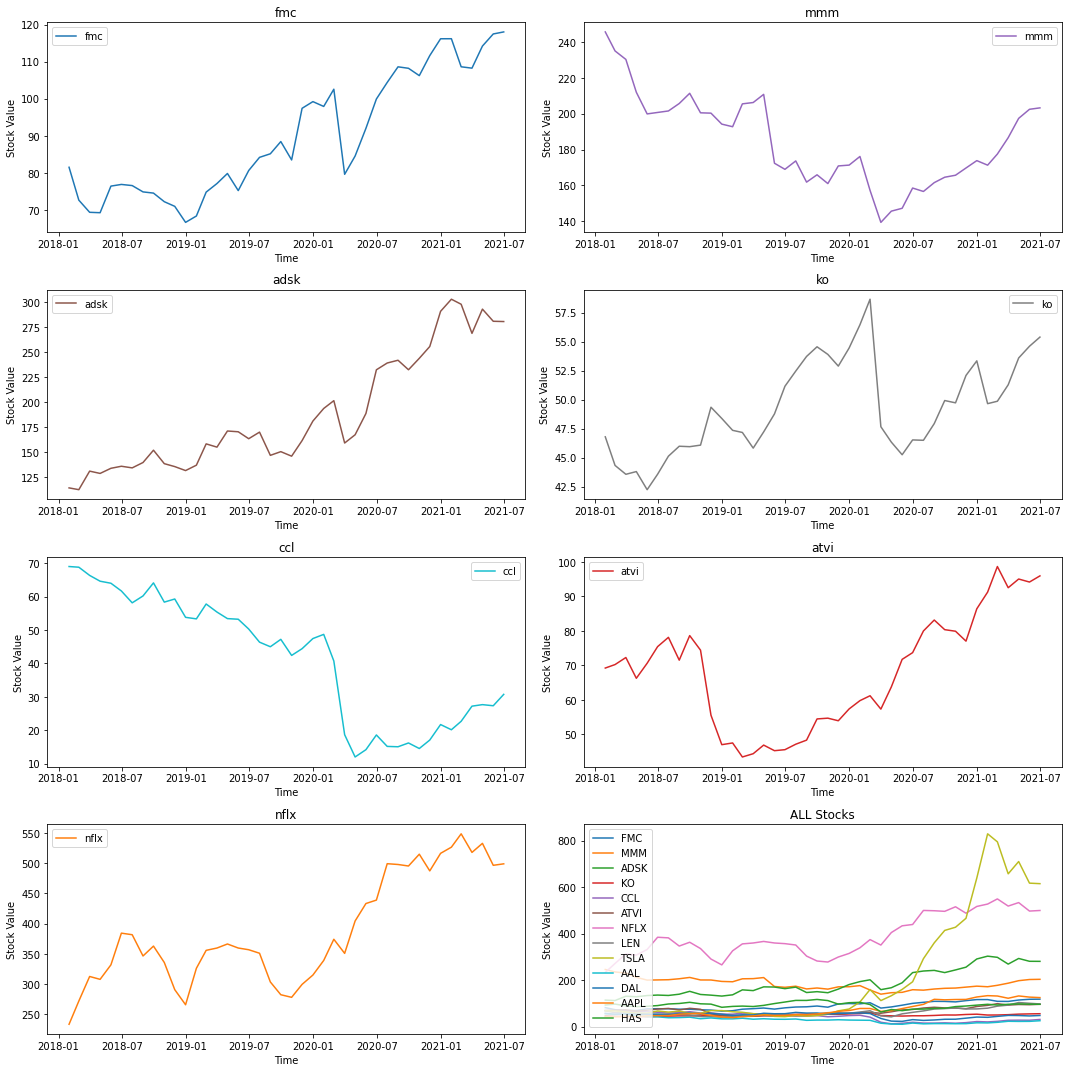

In [894]:
plotClosePrices(df=monthly_close_returns)

Now let's compare the <b>month closing price charts</b> to <b>day closing price charts</b>

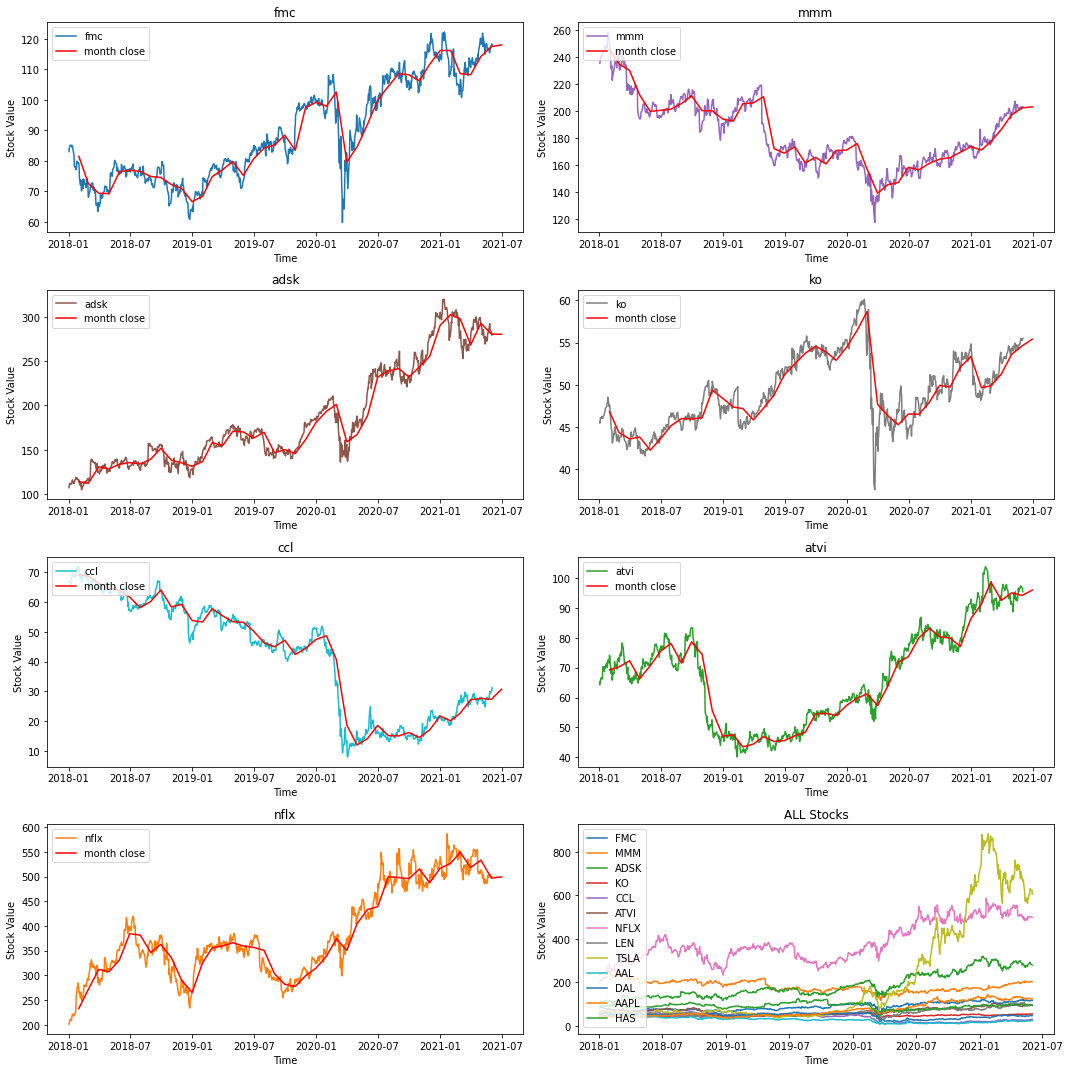

In [895]:
def plotClosePricesMonthDay(df1=close_prices, df2=monthly_close_returns, stock_names=stock_names, nrows=4, ncols=2, figsize=(15,15)):
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.patch.set_facecolor('xkcd:white')

    list_colors = ['tab:blue', 'tab:purple', 'tab:brown', 'tab:gray', 'tab:cyan', 'tab:green', 'tab:orange']

    k = 0
    for i in range(4):
        for j in range(2):
            if k == 7:
                df1 = df1.set_index('Date')
                name = 'ALL Stocks'
                axs[i, j].set_title(name)
                axs[i, j].plot(df1.index, df1)
                axs[i, j].set_xlabel("Time")
                axs[i, j].set_ylabel("Stock Value")
                axs[i, j].legend(stock_names, loc='upper left')
            else:
                name = stock_names[k].lower()
                axs[i, j].set_title(name)
                axs[i, j].plot(df1['Date'], df1[name], color=list_colors[k], label=name)
                axs[i, j].plot(df2['Date'], df2[name], color="red", label="month close")
                axs[i, j].set_xlabel("Time")
                axs[i, j].set_ylabel("Stock Value")
                axs[i, j].legend(loc='upper left')
            k+=1

    fig.tight_layout()
    plt.show()
plotClosePricesMonthDay()

## Log Returns

Log returns can work as a momentum indicator. 

Log returns ($R_t$) from prices ($P_t$):

$$R_t = log_e(P_t) - log_e(P_{t-1})$$

In [896]:
def compute_log_returns(prices):
    """
    Parameters
    ----------
    prices : DataFrame
        Prices for each ticker and date
    
    Returns
    -------
    log_returns : DataFrame
        Log returns for each ticker and date
    """
    prices = prices.set_index('Date')
    prices = np.log(prices) - np.log(prices.shift(1))
    
    return prices

monthly_close_log_returns = compute_log_returns(monthly_close_returns)
monthly_close_log_returns.head()

,fmc,mmm,adsk,ko,ccl,atvi,nflx,len,tsla,aal,dal,aapl,has
Date,,,,,,,,,,,,,
2018-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-28,-0.115221,-0.044133,-0.015828,-0.054113,-0.002974,0.014474,0.153111,-0.135517,-0.008322,-0.057424,-0.075052,-0.037273,0.041792
2018-03-31,-0.046198,-0.020298,0.153362,-0.017406,-0.036324,0.028633,0.139979,-0.008251,-0.060759,0.037211,0.036188,0.040090,-0.083421
2018-04-30,-0.001585,-0.082794,-0.017761,0.005363,-0.026524,-0.086870,-0.015369,-0.030912,-0.086592,-0.131434,-0.026253,-0.027080,-0.037064
2018-05-31,0.098615,-0.058611,0.039238,-0.036245,-0.009470,0.063656,0.075374,-0.078942,0.000274,-0.090892,-0.009627,0.088430,0.017340


Let's visualize such log returns in charts

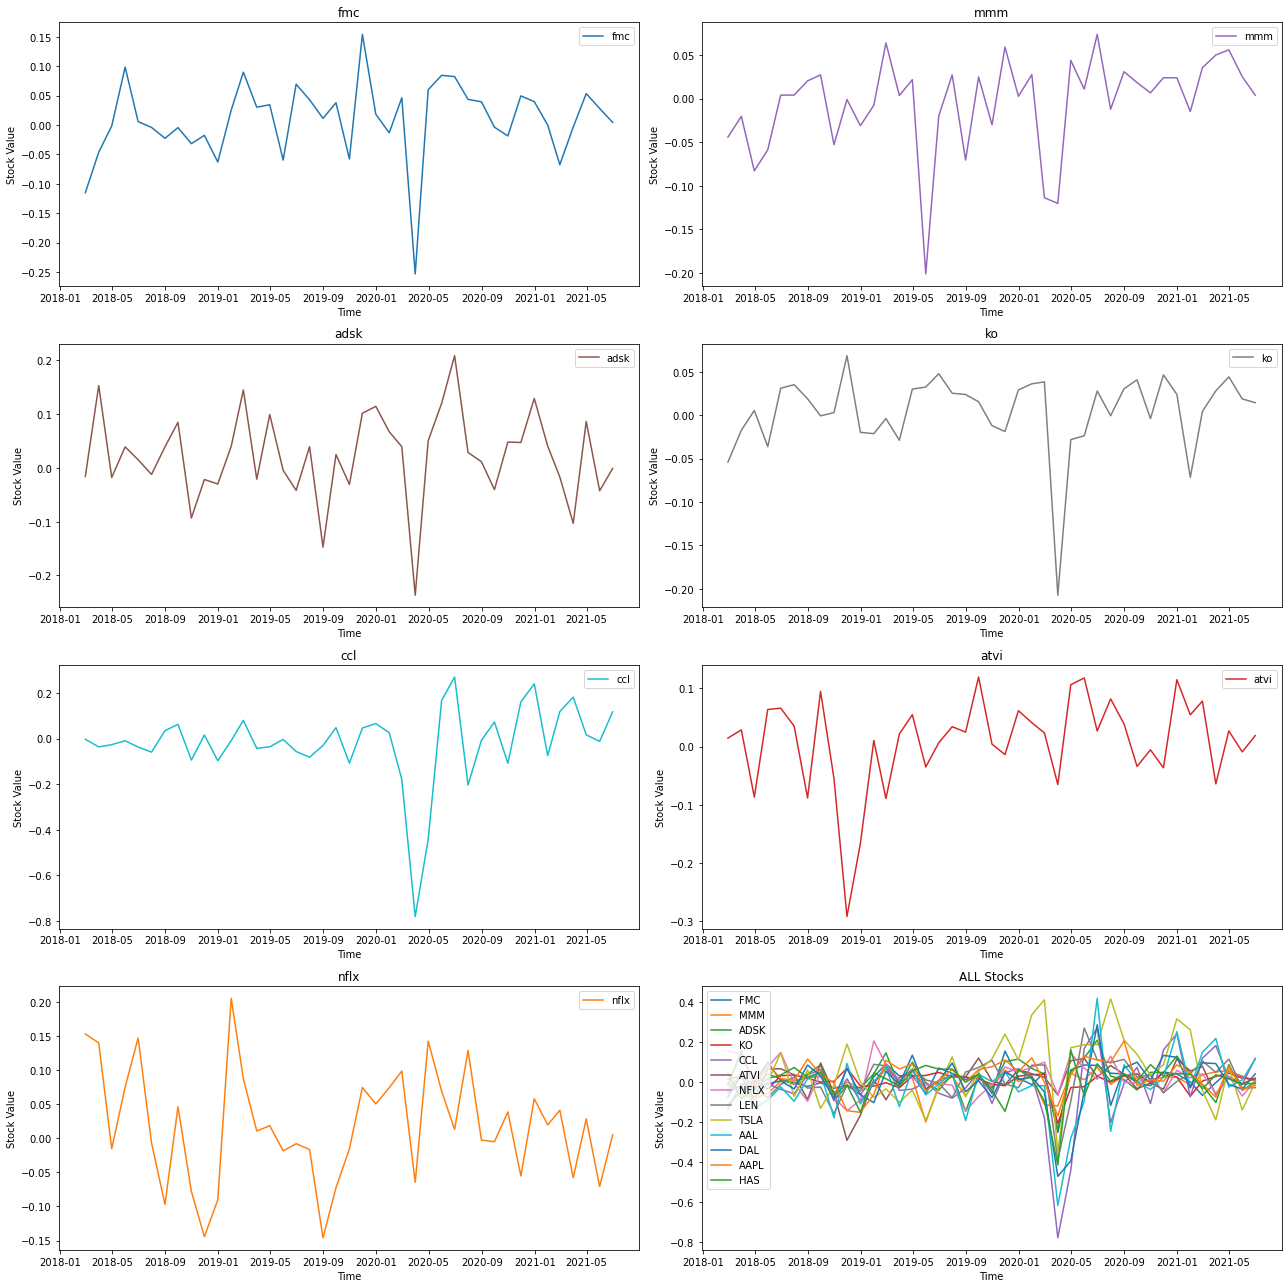

In [897]:
plotClosePrices(df=monthly_close_log_returns.reset_index(), figsize=(18,18))

## Shift Returns

In [898]:
def shift_returns(returns, shift_n):
    """
    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    shift_n : int
        Number of periods to move, can be positive or negative
    
    Returns
    -------
    shifted_returns : DataFrame
        Shifted returns for each ticker and date
    """
    
    return returns.shift(shift_n)

shift_returns(monthly_close_log_returns, 1).head()

,fmc,mmm,adsk,ko,ccl,atvi,nflx,len,tsla,aal,dal,aapl,has
Date,,,,,,,,,,,,,
2018-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-31,-0.115221,-0.044133,-0.015828,-0.054113,-0.002974,0.014474,0.153111,-0.135517,-0.008322,-0.057424,-0.075052,-0.037273,0.041792
2018-04-30,-0.046198,-0.020298,0.153362,-0.017406,-0.036324,0.028633,0.139979,-0.008251,-0.060759,0.037211,0.036188,0.040090,-0.083421
2018-05-31,-0.001585,-0.082794,-0.017761,0.005363,-0.026524,-0.086870,-0.015369,-0.030912,-0.086592,-0.131434,-0.026253,-0.027080,-0.037064


### Shift return applications

With de above function it is possible to compare previous/lookahead_returns values. The section below show us such application in charts.

#### View Data

Let's get the previous month's and next month's returns.

In [899]:
prev_returns = shift_returns(monthly_close_log_returns, 1)
lookahead_returns = shift_returns(monthly_close_log_returns, -1)

In [900]:
def plotPrevLookAhead(stock_name, df1, df2, label1, label2,
                      nrows=1, ncols=1, figsize=(12,4)):
    
    fig, axs = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('xkcd:white')
    
    df1 = df1[stock_name]
    df2 = df2.set_index('Date')[stock_name]

    axs.set_title('Stock: ' + stock_name)
    axs.plot(df1.index, df1, color="blue", label=label1)
    axs.plot(df2.index, df2, color="red", label=label2)
    axs.set_xlabel("Time")
    axs.set_ylabel("Stock Value")
    axs.legend()

    fig.tight_layout()
    plt.show()

#### Previous Returns

Comparisson between monthly close returns and previous returns

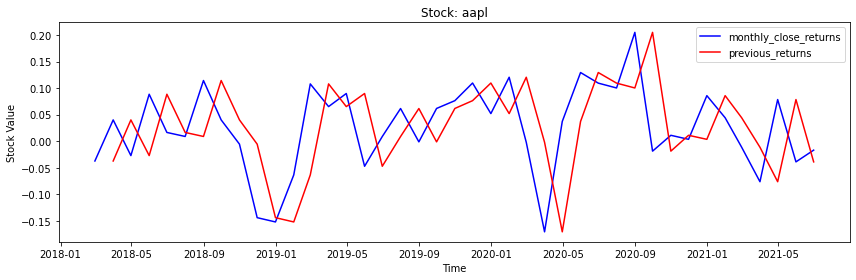

In [901]:
plotPrevLookAhead('aapl', monthly_close_log_returns, prev_returns.reset_index(), 'monthly_close_returns', 'previous_returns')

#### Lookahead returns

Comparisson between monthly close returns and forehead returns

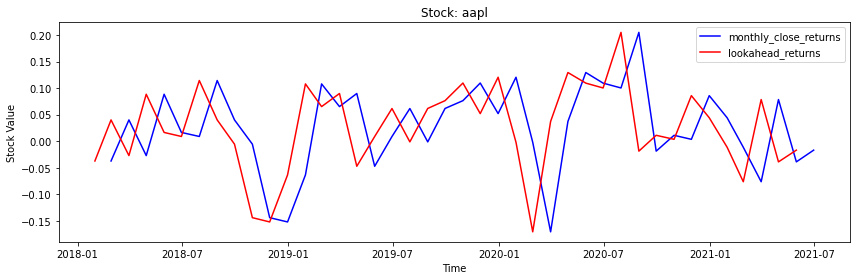

In [902]:
plotPrevLookAhead('aapl', monthly_close_log_returns, lookahead_returns.reset_index(), 'monthly_close_returns', 'lookahead_returns')

## Generate Trading Signal

A trading signal is a sequence of trading actions, or results that can be used to take trading actions. A common form is to produce a "long" and "short" portfolio of stocks on each date (e.g. end of each month, or whatever frequency you desire to trade at). This signal can be interpreted as rebalancing your portfolio on each of those dates, entering long ("buy") and short ("sell") positions as indicated.

The following strategy can be used 

>For each month-end observation period, rank the stocks by previous returns, from the highest to the lowest. Select the top performing stocks for the long portfolio, and the bottom performing stocks for the short portfolio.

In [903]:
def get_top_n(prev_returns, top_n):
    """
    Parameters
    ----------
    prev_returns : DataFrame
        Previous shifted returns for each ticker and date
    top_n : int
        The number of top performing stocks to get
    
    Returns
    -------
    top_stocks : DataFrame
        Top stocks for each ticker and date marked with a 1
    """
    frames = []
    row = 0
    for i, r in prev_returns.iterrows():
        arr = r.nlargest(top_n).values
        boolean_series = r.isin(arr)
        
        frames.append(boolean_series.to_frame().T)
    df = pd.concat(frames)
    
    return df.astype(int)

With that approach we can select the *10 Most Longed Stocks* and *10 Most Shorted Stocks*  
<br/>

**OBS:** If we pass in `-1*prev_returns` instead of just `prev_returns`. Multiplying by negative one will flip all the positive returns to negative and negative returns to positive. Thus, it will return the worst performing stocks.

In [904]:
top_stocks = 4
bottom_stocks = 0
df_long = get_top_n(prev_returns, top_stocks)
df_short = get_top_n(-1*prev_returns, bottom_stocks)

print('{} Most Longed Stocks:'.format(top_stocks))
print(*df_long.sum().nlargest(top_stocks).index, sep = ", ") 
print('\n{} Most Shorted Stocks:'.format(bottom_stocks))
print(*df_short.sum().nlargest(bottom_stocks).index, sep = ", ") 

4 Most Longed Stocks:
tsla, aapl, adsk, len

0 Most Shorted Stocks:



## Projected Returns

It's now time to check if our trading signal has the potential to become profitable.

In [905]:
def portfolio_returns(df_long, df_short, lookahead_returns, n_stocks):
    """
    Parameters
    ----------
    df_long : DataFrame
        Top stocks for each ticker and date marked with a 1
    df_short : DataFrame
        Bottom stocks for each ticker and date marked with a 1
    lookahead_returns : DataFrame
        Lookahead returns for each ticker and date
    n_stocks: int
        The number of stocks chosen for each month
    
    Returns
    -------
    portfolio_returns : DataFrame
        Expected portfolio returns for each ticker and date
    """
    
    return ((df_long - df_short) * lookahead_returns)/n_stocks

n_stocks = 2*top_stocks + 2*bottom_stocks
expected_portfolio_returns = portfolio_returns(df_long, df_short, lookahead_returns, n_stocks)

The expected return using `n_stocks = 2*top_bottom_n` will be:

In [906]:
expected_portfolio_returns.head()

,fmc,mmm,adsk,ko,ccl,atvi,nflx,len,tsla,aal,dal,aapl,has
2018-01-31,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.0,-0.0,-0.000000,-0.0,-0.000000,0.000000
2018-02-28,-0.000000,-0.0,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.0,-0.0,0.000000,0.0,0.000000,-0.000000
2018-03-31,-0.000000,-0.0,-0.000000,0.000000,-0.003315,-0.010859,-0.001921,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.004633
2018-04-30,0.000000,-0.0,0.004905,-0.000000,-0.000000,0.000000,0.009422,-0.0,0.0,-0.011362,-0.0,0.011054,0.000000
2018-05-31,0.000736,0.0,0.001907,0.003879,-0.000000,0.000000,0.018406,-0.0,0.0,-0.000000,0.0,0.000000,0.000000


In [907]:
expected_portfolio_returns_by_date = expected_portfolio_returns.T.sum().dropna()
expected_portfolio_returns_by_date

2018-01-31    0.000000
2018-02-28    0.000000
2018-03-31   -0.020728
2018-04-30    0.014019
2018-05-31    0.024928
2018-06-30    0.004136
2018-07-31   -0.012927
2018-08-31    0.014744
2018-09-30   -0.024907
2018-10-31   -0.039059
2018-11-30   -0.029481
2018-12-31   -0.025296
2019-01-31    0.021356
2019-02-28   -0.003927
2019-03-31    0.030278
2019-04-30   -0.020044
2019-05-31   -0.004263
2019-06-30   -0.008833
2019-07-31    0.004102
2019-08-31    0.019682
2019-09-30    0.005221
2019-10-31    0.040616
2019-11-30    0.024362
2019-12-31    0.063857
2020-01-31    0.022011
2020-02-29   -0.122490
2020-03-31    0.034594
2020-04-30    0.040921
2020-05-31    0.039672
2020-06-30    0.050996
2020-07-31    0.020031
2020-08-31    0.017492
2020-09-30    0.004877
2020-10-31    0.053285
2020-11-30    0.028946
2020-12-31    0.019671
2021-01-31    0.025935
2021-02-28   -0.054194
2021-03-31    0.011637
2021-04-30   -0.001582
2021-05-31   -0.006258
2021-06-30    0.000000
dtype: float64

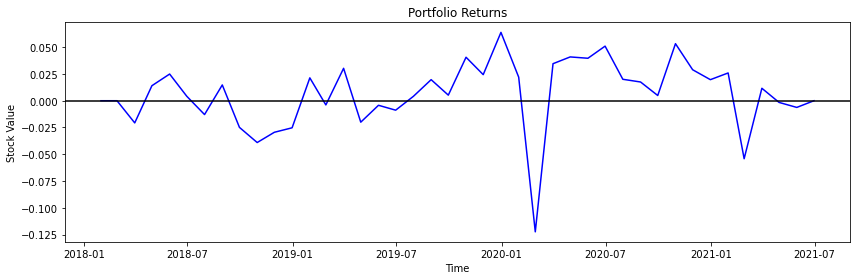

In [908]:
def plotPortfolioReturn(df=portfolio_rtn, nrows=1, ncols=1, figsize=(12,4)):
    
    fig, axs = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('xkcd:white')
    df = expected_portfolio_returns.T.sum()
    
    axs.set_title('Portfolio Returns')
    axs.plot(df.index, df, color="blue")
    axs.axhline(y=0, color='black', linestyle='-')
    axs.set_xlabel("Time")
    axs.set_ylabel("Stock Value")

    fig.tight_layout()
    plt.show()
    
plotPortfolioReturn()

## Statistical Tests

### Annualized Rate of Return

In [909]:
portfolio_ret_mean = expected_portfolio_returns_by_date.mean()
portfolio_ret_ste = expected_portfolio_returns_by_date.sem()
portfolio_ret_annual_rate = (np.exp(portfolio_ret_mean * 12) - 1) * 100

print("""
Mean:                       {:.6f}
Standard Error:             {:.6f}
Annualized Rate of Return:  {:.2f}%
""".format(portfolio_ret_mean, portfolio_ret_ste, portfolio_ret_annual_rate))


Mean:                       0.006271
Standard Error:             0.005021
Annualized Rate of Return:  7.82%



The annualized rate of return allows you to compare the rate of return from this strategy to other quoted rates of return, which are usually quoted on an annual basis. 

### T-Test
Our null hypothesis ($H_0$) is that the actual mean return from the signal is zero. We'll perform a one-sample, one-sided t-test on the observed mean return, to see if we can reject $H_0$.

We'll need to first compute the t-statistic, and then find its corresponding p-value. _The p-value will indicate the probability of observing a t-statistic equally or more extreme than the one we observed if the null hypothesis were true_. A small p-value means that the chance of observing the t-statistic we observed under the null hypothesis is small, and thus casts doubt on the null hypothesis. It's good practice to set a desired level of significance or alpha ($\alpha$) _before_ computing the p-value, and then reject the null hypothesis if $p < \alpha$.

Lets use $\alpha = 0.05$, since it's a common value to use.

In [910]:
def analyze_alpha(expected_portfolio_returns_by_date):
    """
    Parameters
    ----------
    expected_portfolio_returns_by_date : Pandas Series
        Expected portfolio returns for each date
    
    Returns
    -------
    t_value
        T-statistic from t-test
    p_value
        Corresponding p-value
    """
    
    ans = stats.ttest_1samp(expected_portfolio_returns_by_date, 0.0)
    return ans[0], ans[1]/2

ret = analyze_alpha(expected_portfolio_returns_by_date)
print('Alpha analysis')
print('t-value: {}\np-value: {}'.format(ret[0], ret[1]))

Alpha analysis
t-value: 1.2490192852079738
p-value: 0.10937118906658572


If the p-value is lower than a pre-defined number (0.05), the null hypothesis is rejected and we claim that the result is statistically significant and thet the alternative hypothesis is true. Since the p-value from our analysis is `greater` than 0.05 we say that our alternative hypothesis is false.

Now we can create an *algorithm* in order to find how many `long stocks` and `short stocks` we should buy looking forward obtaining `p_value < 0.05`

In [911]:
def findLowPValue(prev_returns=prev_returns, lookahead_returns=lookahead_returns):
    p_value = 100
    for i in range(len(stock_names)):
        top_stocks = i
        for j in range(len(stock_names)):
            bottom_stocks = j
            df_long = get_top_n(prev_returns, top_stocks)
            df_short = get_top_n(-1*prev_returns, bottom_stocks)

            n_stocks = 2*top_stocks + 2*bottom_stocks
            expected_portfolio_returns = portfolio_returns(df_long, df_short, lookahead_returns, n_stocks)

            expected_portfolio_returns_by_date = expected_portfolio_returns.T.sum().dropna()

            portfolio_ret_mean = expected_portfolio_returns_by_date.mean()
            portfolio_ret_ste = expected_portfolio_returns_by_date.sem()
            portfolio_ret_annual_rate = (np.exp(portfolio_ret_mean * 12) - 1) * 100

            ret = analyze_alpha(expected_portfolio_returns_by_date)
            if ret[1] < p_value:
                p_value = ret[1]
            
            if p_value < 0.05 and bottom_stocks > 1:
                break
                
    print('Alpha analysis')
    print('t-value: {}\np-value: {}'.format(ret[0], p_value))
    print('\n---------------\n')
    print('How many stocks to buy:')
    print('top_stocks: ', top_stocks)
    print('bottom_stocks: ', bottom_stocks)
    
findLowPValue()

Alpha analysis
t-value: 1.1856702285534035
p-value: 0.031756091446011984

---------------

How many stocks to buy:
top_stocks:  12
bottom_stocks:  2
